Summary - Pattern Recognition
===============================

This notebook is a summary of many of the techniques we have looked at in pattern recognition,
as well the interfaces and classes used to implement them in the `scikit.learn` package.

In [6]:
from pylab import *
from scipy.spatial import distance
import tables
import random as pyrandom

MNIST Training and Test Data
======================


We have tried out a lot of these algorithms on the MNIST data set.
The MNIST data set has been widely used for experiments in pattern
recognition.
Being based on images, it's actually easy to see what the various
preprocessing methods do with the data.

In [7]:
mnist = tables.openFile("mnist.h5","r")

Most algorithms work on 1D vectors, while input images are 2D.
Furthermore, training data sets are, by convention, matrices whose rows represent training data vectors.
The `make2d` function is useful for converting.

In [8]:
def make2d(data):
    return data.reshape(len(data),prod(data.shape[1:]))

This is the training data...

In [9]:
data = make2d(array(mnist.root.deskewed,'f'))
labels = array(mnist.root.labels)

And this is a separate test set...

In [10]:
test_data = make2d(array(mnist.root.test_deskewed,'f'))
test_labels = array(mnist.root.test_labels)

k-Nearest Neighbors
===================

One of the simplest and most intuitive algorithms for classification
is the nearest neighbor classifier.
You should always try it out to get some idea of how difficult
a classification problem is.
For large amounts of training data, the k-NN classifier can be slow,
but the implementation in SciKit has various optimizations that can
make it a lot faster than the implementation you created yourself.

Scikit classifiers generally start out as an object that is initialized with some parameters.

In [11]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)

Training is performed with the `fit` method.

In [16]:
knn.fit(data[:1000],labels[:1000])

KNeighborsClassifier(algorithm='auto', leaf_size=30, n_neighbors=1,
           warn_on_equidistant=True, weights='uniform')

Classification is carried out with the `predict` method.

In [13]:
pred = knn.predict(test_data)
print pred[:10]
print test_labels[:10]

[7 2 1 0 4 1 9 4 9 9]
[7 2 1 0 4 1 4 9 5 9]

In the past, we have evaluated predictions directly by comparing labels.

In [17]:
sum(pred!=test_labels)*1.0/len(test_labels)

0.076100000000000001

However, the package `sklearn.metrics` contains
various evaluation functions.
The `zero_one_score` function computes the fraction of _correct_ results.

In [14]:
from sklearn import metrics
metrics.zero_one_score(test_labels,pred)

0.92390000000000005

Often, the error rate is more useful.

In [15]:
1-metrics.zero_one_score(test_labels,pred)

0.076099999999999945

Linear Discriminant Analysis
==============================

Linear discriminant analysis (LDA) is one way of obtaining a _linear classifier_.
It is actually based on parametric models, however, not perceptron learning or other
_discriminative_ methods.

In [18]:
from sklearn import lda
lc = lda.LDA()

As before, the `fit` method does the training.

In [19]:
lc.fit(data,labels)

LDA(n_components=None, priors=None)

The `predict` method does the prediction, and we use the `zero_one_score` function to evaluate.

In [123]:
pred = lc.predict(test_data)
1-metrics.zero_one_score(test_labels,pred)

0.081999999999999962

Preprocessing
============

We had talked about various forms of preprocessing.
Often, feature vector normalization is important.
For example, we might transform $v$ into $v/||v||$.

Some preprocessing methods need to be trained with a `fit` method,
just like a classifier,
but instead of a `pred` method, there is a `transform` method.

The `fit_transform` method fits a model and transforms the input data at the same time.

In [124]:
from sklearn import preprocessing
normalizer = preprocessing.Normalizer(norm='l2')
normalized_data = normalizer.fit_transform(data)

Now we can fit a classifier in terms of the transformed data.

In [125]:
lc = lda.LDA()
lc.fit(normalized_data,labels)

LDA(n_components=None, priors=None)

We also need to remember to transform the test data prior to classification.

In [126]:
pred = lc.predict(normalizer.transform(test_data))
1-metrics.zero_one_score(test_labels,pred)

0.077500000000000013

Preprocessing is important for achieving low error rates,
but many attempts at preprocessing make classification worse, not better.
Finding good preprocessing methods is tricky and requires both experience
and experimentation.

Feature Extraction
==================

Feature extraction is a particular form of preprocessing.
There really isn't any clear distinction between feature extraction,
preprocessing, normalization, etc.
Normally, feature extraction aims at reducing the amount of data
and information that needs to be processed by a classifier,
and often it attempts to enhance features of the input that are
relevant to classification and discard parts of the input that
are noise or irrelevant.

In [127]:
from scipy.ndimage.filters import gaussian_filter
def extract(data):
    return array([gaussian_filter(x.reshape(28,28),2.0).ravel() for x in data])

Feature extraction is often hard-coded by hand.

In [128]:
extracted = extract(data)

In [129]:
lc = lda.LDA()
lc.fit(extracted,labels)

LDA(n_components=None, priors=None)

In [130]:
pred = lc.predict(extract(test_data))
1-metrics.zero_one_score(test_labels,pred)

0.080600000000000005

Confusion Matrix
===================

We'd looked already at one function in the `metrics` package, but there
are other useful functions for evaluation and getting insight in how
classifiers work.

The _confusion matrix_ tells us which kinds of classes are most often confused.
For example, '9' and '7' are confused fairly frequently, as are '8' and '3',
due to significant similarity.

Based on confusions, we can often conclude what kind of preprocessing might
be helpful in reducing the error rate.

In [131]:
metrics.confusion_matrix(test_labels,pred)

array([[ 951,    0,    0,    2,    1,   12,    3,    0,    9,    2],
       [   0, 1105,    2,    5,    1,    2,    4,    0,   16,    0],
       [   9,    0,  912,   20,   16,    6,    8,    3,   55,    3],
       [   2,    0,    5,  953,    1,   17,    1,    4,   16,   11],
       [   0,    4,    8,    1,  922,    5,    3,    2,    5,   32],
       [   5,    0,    0,   19,   16,  816,   13,    0,   18,    5],
       [  11,    3,   10,    1,   15,   39,  870,    0,    9,    0],
       [   2,    5,   15,    3,   16,    1,    0,  899,   10,   77],
       [  13,    1,    7,   19,   10,   28,    3,    2,  879,   12],
       [   5,    1,    3,   22,   40,    5,    0,   38,    8,  887]])

Quadratic Discriminant Analysis
================================

Quadratic Discriminant Analysis (QDA) is what we were looking
at under parametric classifiers in previous lectures.

In [132]:
from sklearn import qda
qc = qda.QDA()
qc.fit(data,labels)

QDA(priors=None)

In [133]:
pred = qc.predict(test_data)
1-metrics.zero_one_score(test_labels,pred)

0.21189999999999998

Note that performance isn't very good, since this attempts to infer
a complete covariance matrix from not very much data.

Again, this is different from learning a polynomial classifier discriminatively.

Support Vector Machines
==============

Support vector machines are a popular machine learning technique.
You can think of them as combining ideas from perceptron learning with
non-linear transformations of the input space based on kernels.
As such, the method is quite versatile and can solve lots of problems.

However, both training and classification with SVMs can be kind of slow, and
other methods are often significantly faster.

Algorithmically, they are a bit more complicated than that, but
the numerical details are not all that important for using these methods.

In [135]:
from sklearn import svm
sv = svm.SVC()
sv.fit(data,labels)

SVC(C=1.0, cache_size=200, coef0=0.0, degree=3, gamma=0.00127551020408,
  kernel='rbf', probability=False, scale_C=False, shrinking=True,
  tol=0.001)

In [136]:
pred = sv.predict(test_data)
1-metrics.zero_one_score(test_labels,pred)

0.033599999999999963

Note that performance is fairly good compared to the other methods.
There are a lot of parameters you can tune to improve them further.

Logistic Regression
===================

Another linear classifier that we had mentioned briefly is _logistic regression_.

It computes a linear decision boundary, but uses different methods from LDA or SVM.

In [137]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(data,labels)

LogisticRegression(C=1.0, dual=False, fit_intercept=True, intercept_scaling=1,
          penalty='l2', scale_C=False, tol=0.0001)

In [138]:
pred = lr.predict(test_data)
1-metrics.zero_one_score(test_labels,pred)

0.04930000000000001

ROC Curve
=========

As shown above, classifiers just give a single error rate.
But often, there are different error rates we can achieve.
For a binary classifier, there is the _true positive rate_
(the percentage of true positives classified as such),
and the _false positive rate_ (the percentage of negative
samples classified as positive), and there
is a tradeoff between the two.

The basic idea is to use the value of a _discriminant function_ to make different tradeoffs.
By choosing different cutoff values, we can increase the true positive rate or decreate the
false positive rate.
For this, we need to ask the classifier to return a _degree of confidence_ or the value of
a discriminant function.
There are multiple candidates for this, including `predict_log_proba`.

In [139]:
scores = lr.predict_log_proba(test_data)

The function `metrics.roc_curve` will then generate an ROC curve. 
It only does this for binary classification tasks, so here we look at
0 vs. everything else.

In [140]:
fpr,tpr,thresholds = metrics.roc_curve(test_labels==0,scores[:,0])

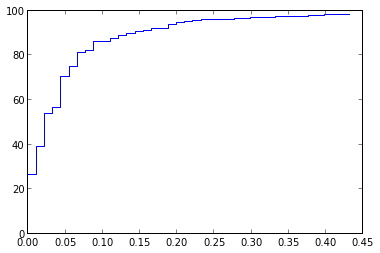

In [141]:
plot(100*fpr[:1000],100*tpr[:1000])

Cross Validation
================

We have seen several times that evaluating a classifier on the training
set yields lower error rates than evaluating it on new data.

In [142]:
from sklearn import cross_validation
from sklearn import linear_model

cl = linear_model.LogisticRegression()
cl.fit(data[:1000],labels[:1000])
pred = cl.predict(data[:1000])
print metrics.zero_one_score(labels[:1000],pred)

0.999

In [143]:
pred = cl.predict(test_data)
print metrics.zero_one_score(test_labels,pred)

0.9108

If we don't have a separate test set, we can use _cross validation_ for estimating the
true error rate of a classifier.

Cross-validation splits the training data itself into a separate test and training set,
but it does so multiple times and then reports the error rate for each split.

In [144]:
scores = cross_validation.cross_val_score(cl,data[:1000],labels[:1000],cv=10)

In [145]:
print scores
print mean(scores)

[ 0.94  0.94  0.94  0.93  0.93  0.95  0.93  0.97  0.9   0.9 ]
0.933

Dimensionality Reduction via PCA
==================

We have talked about manual preprocessing and feature extraction steps.
We also saw one important automatic feature extraction step.

Remember that PCA is a linear transformation that reduces the dimensionality of the input,
while preserving distances as much as possible.
It is an example of _unsupervised learning_.

In [146]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=50)
pca.fit(data)

PCA(copy=True, n_components=50, whiten=False)

In [147]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(pca.transform(data),labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, n_neighbors=3,
           warn_on_equidistant=True, weights='uniform')

In [148]:
pred = knn.predict(pca.transform(test_data))

In [149]:
1-metrics.zero_one_score(test_labels,pred)

0.01529999999999998

Clustering with k-Means
=======================

A second form of unsupervised learning we looked at is $k$-means clustering.

$k$-means clustering attempts to identify representative patters in the input data.

$k$-means clustering has a number of applications:

- we can use it to visualize the structure of the data
- we can use it to create "pseudoclasses" that can then be used with, say, a QDA (this gives a classifier somewhat similar to a kernel-based classifier)
- we can use it as kernel centers for kernel-based methods

In [150]:
from sklearn import cluster
km = cluster.KMeans(40)
km.fit(data[::10])

KMeans(copy_x=True, init='k-means++', k=40, max_iter=300, n_init=10,
    precompute_distances=True,
    random_state=<mtrand.RandomState object at 0x7fadbbe4a498>, tol=0.0001,
    verbose=0)

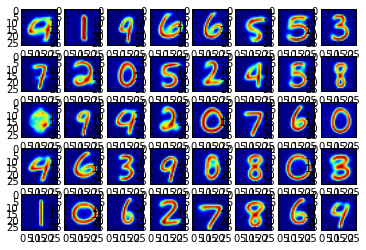

In [151]:
for i,v in enumerate(km.cluster_centers_):
    subplot(5,8,i+1)
    imshow(v.reshape(28,28))

In [152]:
pseudoclasses = km.predict(data)
pseudoclasses[:10]

array([11, 23, 24,  1,  2, 19,  1, 31, 32, 13])